# Analyses for CinC paper about source detection

## First, load stuff and define some functions

In [1]:
import os,sys
import numpy as np
import vtk
from vtk.util.numpy_support import numpy_to_vtk,numpy_to_vtkIdTypeArray,vtk_to_numpy
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist,pdist,squareform
from sklearn import metrics
import pandas as pd
from skimage.morphology import binary_dilation as imdilation


upperDir = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(upperDir,'aux-functions'))
sys.path.append(os.path.join(upperDir,'recurrence'))

import IgbHandling as igb
import quick_visualization as qv
import egm_processing as egmp


# Functions
def MakeAdjacencyMatrix(tissuePatch,SpatialResolution):
    '''
    Generates the adjacency matrix for a cloud of points obtained from an igb

    Parameters
    ----------
    tissuePatch : N,3 np array
        Points of the tissue patch (3D but could be 2D).
    spatialResolution : float, optional
        The spatial resolution of the igb. The default is 1.

    Returns
    -------
    AdjacencyMatrix : TYPE
        DESCRIPTION.

    '''

    Distances = pdist(tissuePatch, 'euclidean').astype(np.int16)
    Distances[Distances<=SpatialResolution*np.sqrt(2)] = -1
    Distances[Distances>SpatialResolution*np.sqrt(2)] = 0
    Distances = -Distances.astype(np.int16)

    AdjacencyMatrix = squareform(Distances)


    return AdjacencyMatrix

def GeodesicDistances(Source,AdjacencyMatrix,EdgeWeight = 1):
    Distances = np.ones(AdjacencyMatrix.shape[0])*np.nan
    Distances[Source] = 0

    Vertex = Source
    InSet = np.ones_like(Distances);   

    Visited = []
    while True:
        #Include u to sptSet.
        Visited.append(Vertex)
        #Update distance value of all adjacent vertices of u. 
        #To update the distance values, iterate through all adjacent vertices. 
        #For every adjacent vertex v, if the sum of a distance value of u (from source) 
        #and weight of edge u-v, is less than the distance value of v, then update the distance value of v. 

        Neighbors = np.where(AdjacencyMatrix[Vertex,:]==1)[0]
        for i,v in enumerate(Neighbors):
            if Distances[Vertex]+EdgeWeight<Distances[v] or np.isnan(Distances[v]):
                Distances[v] = Distances[Vertex]+EdgeWeight

        InSet[Vertex] = np.nan
        if np.nansum(InSet)==0:
            break

        #check minimum distance
        temp = np.where(~np.isnan(Distances)*(~np.isnan(InSet)))[0]

        # Check if in set        
        try:
            Vertex = temp[np.where(Distances[temp]==np.nanmin(Distances[temp]))[0][0]]    
        except:
            Vertex = np.where(~np.isnan(InSet))[0][0]
            
    return Distances


## Load anatomy and individual chambers

In [2]:
#%% Load Anatomy and labels for initial points
anatomyPath =r'D:\vgmar\model_data\anatomy\model30Box' #'/mnt/d/vgmar/model_data/anatomy/model30Box' #
modelName = 'model24-30Box'
FullCell = igb.LoadCellFile(anatomyPath,modelName,[50,51])
nz,ny,nx = FullCell.shape
Anatomy,veIndexes = igb.GetDataIndexes(anatomyPath,modelName,FullCell,validCells = [50,51])
scale = 1 # mm


interAtrialConnections,CSInds,LAInds,RAInds = igb.GetAnatomicalInds(anatomyPath,(nx,ny,nz),Anatomy)

initialPoints = np.array([20383, 15497, 5654, 1110, 21897, 12919, 24652, 18574, 3218, 21553, 5736,
                          2548, 8756, 22228, 17290, 9391, 9541, 19127, 15307, 12715]) # Determined by getting the center of 20 k-means clusters

LA_Seeds = np.where(np.isin(initialPoints,LAInds))[0]
RA_Seeds = np.where(np.isin(initialPoints,RAInds))[0]

# Make Anatomy adjacency Matrix

AdjacencyMatrixLA = MakeAdjacencyMatrix(Anatomy[LAInds],1)
AdjacencyMatrixRA = MakeAdjacencyMatrix(Anatomy[RAInds],1)

## Define and load data related to the classification output

The classification has to be adjusted for focal points detected in the septal region, but everything else is fine

In [3]:
#%% Define correct values for classification and source position

Labels_LAExp = np.zeros(len(initialPoints),int)
Labels_RAExp = np.zeros(len(initialPoints),int)

Labels_LAExp[LA_Seeds] = 1 # rotor
Labels_LAExp[RA_Seeds] = 3 # other atrium

Labels_RAExp[LA_Seeds] = 3 # other atrium
Labels_RAExp[RA_Seeds] = 1 # rotor

In [4]:
#%% Load classification results

resultsPath =  r'D:\vgmar\model_data\EX0008\source_tracking_v3'#'/mnt/d/vgmar/model_data/EX0008/source_tracking_endless' #

experimentNames = []
for file in os.listdir(resultsPath):
    if file.startswith('EX0008') and file.endswith('_ClassificationOutput.npy'):
        experimentNames.append(file.split('_ClassificationOutput.npy')[0])
experimentNames = np.sort(experimentNames)

LAExps = np.array([0,1,2,3,4])
RAExps = np.array([5,6,7])


ClassificationResults = {}
FinalPosition = {}
AllPositions = {}
experimentLabels = {}

for experimentIndex,experimentName in enumerate(experimentNames):
    ClassificationResults[experimentIndex] = np.load(os.path.join(resultsPath,
                                    experimentName+'_ClassificationOutput.npy')).astype(int)
    FinalPosition[experimentIndex] = np.load(os.path.join(resultsPath,
                                    experimentName+'_SourceLocations.npy'))
    AllPositions[experimentIndex] = np.load(os.path.join(resultsPath,
                                    experimentName+'_AllCatCenters.npy'),allow_pickle=True)

    if experimentIndex in LAExps:
        experimentLabels[experimentIndex] = Labels_LAExp
    else:
        experimentLabels[experimentIndex] = Labels_RAExp
    


In [5]:
# Adjust points on the septum
# When the classification was performed, the septum was not considered as an area of connection between atria
# However, if the final position was in the septum and the detection was focal, it should be marked as "other atrium"

#Define septal indexes
septumIndices = RAInds[np.isin(RAInds,LAInds)]

SeptumCell = np.zeros_like(FullCell)
SeptumCell[Anatomy[septumIndices,2],Anatomy[septumIndices,1],Anatomy[septumIndices,0]] = 1
SeptumCell = imdilation(SeptumCell,np.ones((8,8,8)))
zz,yy,xx = np.where(SeptumCell)

septumIndices = [np.where((Anatomy[:,0]==xx[i])&(Anatomy[:,1]==yy[i])&(Anatomy[:,2]==zz[i]))[0] for i in range(len(xx))]

nonEmptyInds = [i for i in range(len(septumIndices)) if len(septumIndices[i])!=0]
septumIndices = np.array(septumIndices,object)[nonEmptyInds]
septumIndices = septumIndices.astype(int).squeeze()

# Now for each experiment, check if the position is in the septal region, and if there was a focal detection (2), change to 3
for experimentIndex,experimentName in enumerate(experimentNames):
    
    expLen = len(ClassificationResults[experimentIndex])
    for seedIndex in range(expLen):
        finalPosition = FinalPosition[experimentIndex][seedIndex]
        
        inSeptum = np.isin(finalPosition[0],Anatomy[septumIndices,0])&\
                   np.isin(finalPosition[1],Anatomy[septumIndices,1])&\
                   np.isin(finalPosition[2],Anatomy[septumIndices,2])
        
        focalClassification = ClassificationResults[experimentIndex][seedIndex,0]==2
        
        if inSeptum and focalClassification:  
            print(experimentIndex,seedIndex)
            ClassificationResults[experimentIndex][seedIndex,0] = 3

## Calculate the average position of the rotor over the simulation

In [6]:
# psPath = '/mnt/d/vgmar/model_data/EX0008/psdetection/Filtered'#r'D:\vgmar\model_data\EX0008\psdetection'#

# GlobalAnatomyPSAverageLocations = list()
# for experimentIndex,experimentName in enumerate(experimentNames):
#     # Load PD dataframe
#     PS_DF = pd.read_csv(os.path.join(psPath,experimentName+'_pstracker_th100.txt'),sep=' ', #<<<<<<<< Adjust
#                         dtype = {'t':int, 'x':float, 'y':float, 'z':float,'traj':int},
#                         header = 1,names=['t','x','y','z','traj'],engine='c',
#                         skipinitialspace=True,skiprows=0)
#     scale = 0.2
#     PS_DF['x'] *= scale
#     PS_DF['y'] *= scale
#     PS_DF['z'] *= scale

#     PS_DF = PS_DF.loc[PS_DF['t']>=1000,['x','y','z']]

#     PSAverageLocation = np.asarray(PS_DF.mean())
    
#     # Project to Anatomy
#     psDistances = np.linalg.norm(Anatomy-PSAverageLocation,axis=1)
#     psIndex = np.where(psDistances==np.min(psDistances))[0][0]
    
#     GlobalAnatomyPSAverageLocations.append(Anatomy[psIndex])
# GlobalAnatomyPSAverageLocations

psPath = r'D:\vgmar\model_data\EX0008\psdetection\Filtered'#'/mnt/d/vgmar/model_data/EX0008/psdetection/Filtered'#

lSegment = 1000 # length of the segments
maxSteps = 11
PSAverageLocations = {}
GlobalPSAverageLocations = list()
for experimentIndex,experimentName in enumerate(experimentNames):
    # Load PD dataframe
    # PSD = pd.read_csv(os.path.join(psPath,
    #                 '%s_PSPositionsAndDistances_Overlap.csv'%experimentName),
    #                 skipinitialspace=True)
    # PSD = PSD.loc[:,['t','x','y','z']]
    PSD = pd.read_csv(os.path.join(psPath,experimentName+'_pstracker_th100.txt'),sep=' ', #<<<<<<<< Adjust
                        dtype = {'t':int, 'x':float, 'y':float, 'z':float,'traj':int},
                        header = 1,names=['t','x','y','z','traj'],engine='c',
                        skipinitialspace=True,skiprows=0)
    scale = 0.2
    PSD['x'] *= scale
    PSD['y'] *= scale
    PSD['z'] *= scale
    GlobalPSAverageLocations.append(np.asarray(PSD.loc[:,['x','y','z']].mean()))

    # Choose appropriate anatomy
    if experimentIndex in LAExps:
        chosenAnatomy = Anatomy[LAInds]
    else:
        chosenAnatomy = Anatomy[RAInds]
        
    timeSteps = ClassificationResults[experimentIndex][:,1]
    PSPositions = np.zeros((len(timeSteps)),int)
    
    for seedIndex,numberOfSteps in enumerate(timeSteps):
        # Find valid positions for time segment
        validTimeSteps = (PSD['t']>=(numberOfSteps%maxSteps)*lSegment) & (PSD['t']<(numberOfSteps%maxSteps+1)*lSegment)
        positions = PSD.loc[validTimeSteps,['x','y','z']]

        # Find closest point to anatomy so we can calculate surface distance
        distancesAnatomy = np.linalg.norm(chosenAnatomy-np.asarray(positions.mean()),axis=1)
        anatomyIndex = np.where(distancesAnatomy == np.min(distancesAnatomy))[0][0]

        PSPositions[seedIndex] = anatomyIndex
    
    PSAverageLocations[experimentIndex] = PSPositions

In [7]:
# Do this next two cells in daint :D
import multiprocessing as mp 
from itertools import repeat

def GetSeedDistance(AdjacencyMatrix,Anatomy,Positions,target):
    distances = list()
    for seedIndex,seedPosition in enumerate(Positions):
        source = np.where((Anatomy[:,0]==seedPosition[0])&
                          (Anatomy[:,1]==seedPosition[1])&
                          (Anatomy[:,2]==seedPosition[2]))[0][0]
        path,StepDists = egmp.GetShortestPath(AdjacencyMatrix,Anatomy,source,target)
        distances.append(StepDists[PSAverageIdx])
    return distances

In [ ]:

Distances = {}
for experimentIndex,experimentName in enumerate(experimentNames):
    print('Exp %d'%experimentIndex)
    if experimentIndex in LAExps:
        chosenAnatomy = Anatomy[LAInds]
        AdjacencyMatrix = AdjacencyMatrixLA
        seeds = LA_Seeds
    else:
        chosenAnatomy = Anatomy[RAInds]
        AdjacencyMatrix = AdjacencyMatrixRA
        seeds = RA_Seeds

    # PSAverageIdx = np.where( (chosenAnatomy[:,0]==GlobalAnatomyPSAverageLocations[experimentIndex][0])&
    #                         (chosenAnatomy[:,1]==GlobalAnatomyPSAverageLocations[experimentIndex][1])&
    #                         (chosenAnatomy[:,2]==GlobalAnatomyPSAverageLocations[experimentIndex][2]))[0][0]


    with mp.Pool(2) as pool:
        Output = pool.starmap(GetSeedDistance,
                            zip(repeat(AdjacencyMatrix), \
                                repeat(chosenAnatomy),\
                                AllPositions[experimentIndex][seeds],#[seedPosition for seedPosition in AllPositions[experimentIndex][seeds]],
                                PSAverageLocations[experimentIndex],))
                                # repeat(PSAverageIdx),))
    Distances[experimentIndex] = Output


Exp 0


In [8]:
# Load the results from daint here
import pickle5 as pickle
with open(os.path.join(resultsPath,'AllPositionDistances.pkl'), 'rb') as input:
    AllDistances = pickle.load(input)

In [9]:
# Make boxes for plotting
# BoxExperiments = {}
boxesLA = [[] for i in range(30)]

for experimentIndex,experimentName in enumerate(experimentNames[:5]):
    # boxes = [[] for i in range(30)]
    for di,distances in enumerate(AllDistances[experimentIndex]):
        for ii, element in enumerate(distances):
            if ii>29: 
                boxesLA[29].append(element)
            else:
                boxesLA[ii].append(element)
    # BoxExperiments[experimentIndex] = boxes

boxesRA = [[] for i in range(30)]

for experimentIndex,experimentName in enumerate(experimentNames[5:]):
    # boxes = [[] for i in range(30)]
    for di,distances in enumerate(AllDistances[experimentIndex]):
        for ii, element in enumerate(distances):
            if ii>29: 
                boxesRA[29].append(element)
            else:
                boxesRA[ii].append(element)

Text(0.5, 0.98, 'Distances from average core position for reentries and starting points in the LA')

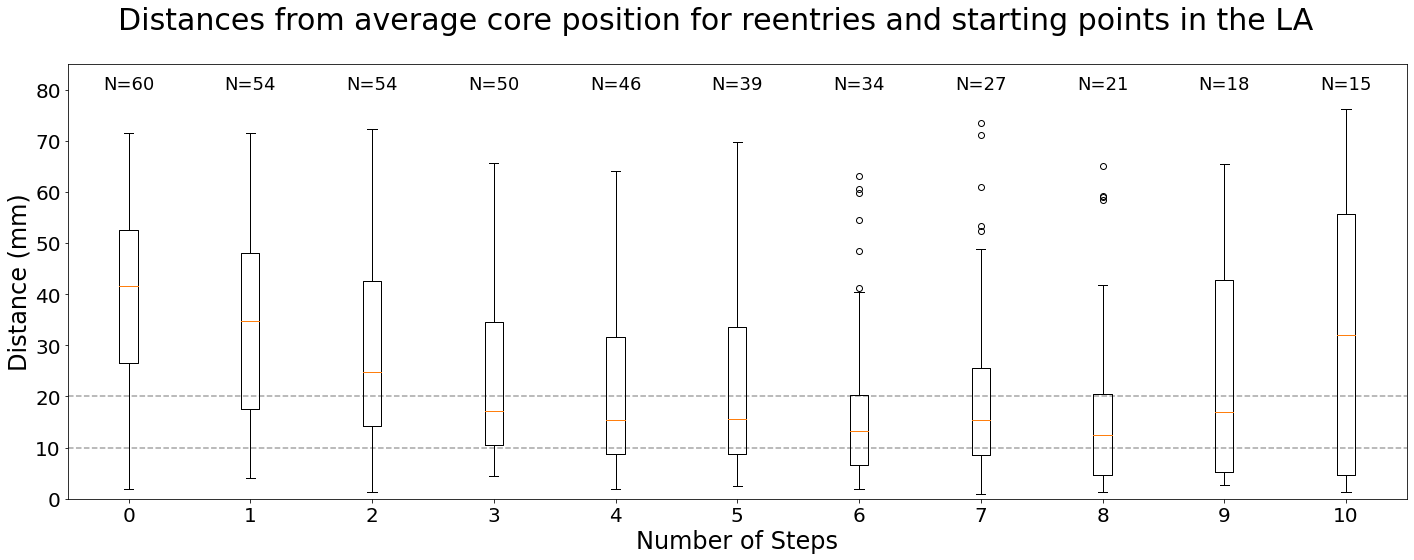

In [10]:
fig,ax = plt.subplots(1,figsize = (24,8))

for i in range(11):
    ax.boxplot(boxesLA[i],positions = [i+.5])
    ax.text(i+.5,80,'N='+str(len(boxesLA[i])),fontsize=18,ha='center')

ax.hlines(20,0,29,linestyle = 'dashed',color= 'gray',alpha=0.7)
ax.hlines(10,0,29,linestyle = 'dashed',color= 'gray',alpha=0.7)
ax.set_xlim([0,11])
ax.set_ylim([0,85])
ax.set_xticks(np.arange(0,11)+.5)
ax.set_xticklabels(np.arange(11),fontsize=20)
ax.set_yticks(np.arange(0,90,10))
ax.set_yticklabels(np.arange(0,90,10),fontsize=20)
ax.set_xlabel('Number of Steps',fontsize = 24)
ax.set_ylabel('Distance (mm)',fontsize = 24)
fig.suptitle('Distances from average core position for reentries and starting points in the LA',fontsize =30)

# fig,ax = plt.subplots(1,figsize = (24,8))

# for i in range(11):
#     ax.boxplot(boxesRA[i],positions = [i+.5])
#     ax.text(i+.5,75,'N='+str(len(boxesRA[i])),fontsize=18,ha='center')

# ax.hlines(20,0,29,linestyle = 'dashed',color= 'gray',alpha=0.7)
# ax.hlines(10,0,29,linestyle = 'dashed',color= 'gray',alpha=0.7)
# ax.set_xlim([0,11])
# ax.set_xticks(np.arange(0,11)+.5)
# ax.set_xticklabels(np.arange(11),fontsize=20)
# ax.set_yticks(np.arange(0,90,10))
# ax.set_yticklabels(np.arange(0,90,10),fontsize=20)
# ax.set_xlabel('Number of Steps',fontsize = 24)
# ax.set_ylabel('Distance (mm)',fontsize = 24)
# fig.suptitle('Distances from average core position for reentries and starting points in the RA',fontsize =30)

In [11]:
# fig,ax = plt.subplots(1,figsize = (24,16))
# for experiment in range(0,5):
#     for di,distances in enumerate(AllDistances[experiment]):
#         ax.plot(distances,color = 'lightgrey')
#         ax.plot(len(distances)-1,distances[-1],'.',color = 'lightgrey',markersize= 30)
# ax.set_xlim([0,10])

# Plot all trajectories?

## Calculate the average distance between the located rotational source and the true rotor

In [7]:
#%% 
# Get the average position of the rotor when the source was found or the simulation
# stopped

psPath =r'D:\vgmar\model_data\EX0008\psdetection\Filtered'# '/mnt/d/vgmar/model_data/EX0008/psdetection/Filtered'#

lSegment = 1000 # length of the segments
maxSteps = 11
PSAverageLocations = {}
GlobalPSAverageLocations = list()
for experimentIndex,experimentName in enumerate(experimentNames):
    # Load PD dataframe
    # PSD = pd.read_csv(os.path.join(psPath,
    #                 '%s_PSPositionsAndDistances_Overlap.csv'%experimentName),
    #                 skipinitialspace=True)
    # PSD = PSD.loc[:,['t','x','y','z']]
    PSD = pd.read_csv(os.path.join(psPath,experimentName+'_pstracker_th100.txt'),sep=' ', #<<<<<<<< Adjust
                        dtype = {'t':int, 'x':float, 'y':float, 'z':float,'traj':int},
                        header = 1,names=['t','x','y','z','traj'],engine='c',
                        skipinitialspace=True,skiprows=0)
    scale = 0.2
    PSD['x'] *= scale
    PSD['y'] *= scale
    PSD['z'] *= scale
    GlobalPSAverageLocations.append(np.asarray(PSD.loc[:,['x','y','z']].mean()))

    # Choose appropriate anatomy
    if experimentIndex in LAExps:
        chosenAnatomy = Anatomy[LAInds]
    else:
        chosenAnatomy = Anatomy[RAInds]
        
    timeSteps = ClassificationResults[experimentIndex][:,1]
    PSPositions = np.zeros((len(timeSteps)),int)
    
    for seedIndex,numberOfSteps in enumerate(timeSteps):
        # Find valid positions for time segment
        validTimeSteps = (PSD['t']>=(numberOfSteps%maxSteps)*lSegment) & (PSD['t']<(numberOfSteps%maxSteps+1)*lSegment)
        positions = PSD.loc[validTimeSteps,['x','y','z']]

        # Find closest point to anatomy so we can calculate surface distance
        distancesAnatomy = np.linalg.norm(chosenAnatomy-np.asarray(positions.mean()),axis=1)
        anatomyIndex = np.where(distancesAnatomy == np.min(distancesAnatomy))[0][0]

        PSPositions[seedIndex] = anatomyIndex
    
    PSAverageLocations[experimentIndex] = PSPositions

In [8]:
PSAverageLocations

{0: array([7091, 6912, 6912, 6906, 7269, 6912, 6906, 6906, 6906, 6912, 6347,
        6912, 7091, 6912, 6912, 6906, 6532, 6912, 6906, 7269]),
 1: array([6783, 6594, 6783, 6783, 6783, 6783, 6783, 6783, 6783, 6783, 6594,
        6783, 6783, 6783, 6783, 6783, 6783, 6594, 6594, 6783]),
 2: array([4192, 4372, 3569, 3569, 1401, 4192, 4372, 3569, 5647, 5352, 1317,
        4462, 5352, 4372, 5658, 4372, 4192, 1401, 5658, 4372]),
 3: array([5956, 2380, 8315, 2828, 5956, 5956, 5956, 3848, 9541, 9355, 9355,
        3848, 9355, 2828, 2828, 9541, 9541, 8315, 3031, 2828]),
 4: array([6421, 6421, 6412, 6421, 6611, 6412, 6421, 5993, 6421, 6217, 6611,
        6421, 6421, 6611, 6611, 6421, 6421, 6611, 5993, 6412]),
 5: array([2134, 2124, 2124, 2124, 2124, 2124, 2514, 2124, 2124, 2124, 2124,
        2134, 2134, 2124, 2124, 2514, 2124, 2124, 2124, 2124]),
 6: array([4188, 4188, 4185, 4457, 5039, 4188, 4188, 4457, 4185, 4457, 4185,
        5039, 4188, 4185, 4457, 4457, 4457, 4185, 4188, 4188]),
 7: array([89

In [9]:
# Get distances between source and last position in cases where a rotor was or wasn't found
# Sources in the other atrium are not considered
# This cell takes a loooong time to run

FinalDistances = {}
SeedCategories = {}
for experimentIndex,experimentName in enumerate(experimentNames):
    print(experimentIndex)
    # Choose appropriate anatomy
    if experimentIndex in LAExps:
        chosenAnatomy = Anatomy[LAInds]
        AdjacencyMatrix = AdjacencyMatrixLA
    else:
        chosenAnatomy = Anatomy[RAInds]
        AdjacencyMatrix = AdjacencyMatrixRA
    
    expLen = len(ClassificationResults[experimentIndex])
    finalDistance = -np.ones(expLen)
    Category = -np.ones(expLen)

    for seedIndex in range(expLen):
        # first category: rotor that was found
        if (ClassificationResults[experimentIndex][seedIndex,0]==1) &\
           (experimentLabels[experimentIndex][seedIndex]==1):
            Category[seedIndex] = 0
        
        # second category: rotor that was not found
        elif (ClassificationResults[experimentIndex][seedIndex,0]==0) &\
             (experimentLabels[experimentIndex][seedIndex]==1):
            Category[seedIndex] = 1
        
        else: 
            continue
        
        Center = FinalPosition[experimentIndex][seedIndex]
        centerIndex = np.where( (chosenAnatomy[:,0]==Center[0])&
                                (chosenAnatomy[:,1]==Center[1])&
                                (chosenAnatomy[:,2]==Center[2]))[0][0]

        Distances = GeodesicDistances(centerIndex,AdjacencyMatrix)
        finalDistance[seedIndex] = Distances[PSAverageLocations[experimentIndex][seedIndex]]
    
    FinalDistances[experimentIndex] = finalDistance
    SeedCategories[experimentIndex] = Category
        # 


0
1
2
3
4
5
6
7


In [22]:
FinalDistances

{0: array([ 7.,  5., -1., -1.,  9.,  7.,  5.,  2., -1.,  4., -1., -1., -1.,
         7.,  3., -1., -1.,  6.,  7.,  8.]),
 1: array([ 9., 11., -1., -1.,  7.,  7.,  7.,  5., -1.,  6., -1., -1., -1.,
        -1., 46., -1., -1., 18.,  5.,  5.]),
 2: array([ 8.,  7., -1., -1., 19.,  9., -1., -1., -1., 23., -1., -1., -1.,
        -1., 10., -1., -1., 21.,  7., 29.]),
 3: array([45., 48., -1., -1., 36., 49., 48., 51., -1.,  7., -1., -1., -1.,
        51., -1., -1., -1., 16., 54., 42.]),
 4: array([ 7.,  3., -1., -1.,  7.,  2.,  1.,  6., -1.,  7., -1., -1., -1.,
         4.,  7., -1., -1.,  1.,  4.,  2.]),
 5: array([-1., -1.,  3.,  3., -1., -1., -1., -1., -1., -1., -1.,  0., -1.,
        -1., -1.,  3., -1., -1., -1., -1.]),
 6: array([-1., -1., 16.,  9., -1., -1., -1., -1.,  5., -1., 35.,  4.,  5.,
        -1., -1., 10.,  5., -1., -1., -1.]),
 7: array([-1., -1., 14.,  5., -1., -1., -1., -1., 12., -1., 18., 23., -1.,
        -1., -1., 13.,  9., -1., -1., -1.])}

In [23]:
# Get mean and std of distances when found or not found
DistancesWhenFound = np.array([element for experimentIndex in range(len(experimentNames)) \
                              for element in FinalDistances[experimentIndex][SeedCategories[experimentIndex]==0]])
truePositive = DistancesWhenFound<=10

DistancesWhenMissed = np.array([element for experimentIndex in range(len(experimentNames)) \
                              for element in FinalDistances[experimentIndex][SeedCategories[experimentIndex]==1]])

print('Number of false rotor detections: %d'%(np.sum(DistancesWhenFound>20)))
print('Average distance when found: %0.2f +- %0.2f mm'%(np.mean(DistancesWhenFound[truePositive]),
                                                        np.std(DistancesWhenFound[truePositive])))
print('Average distance when missed: %0.2f +- %0.2f mm'%(np.mean(DistancesWhenMissed),np.std(DistancesWhenMissed)))

Number of false rotor detections: 15
Average distance when found: 5.62 +- 2.43 mm
Average distance when missed: nan +- nan mm


In [ ]:
for experimentIndex,experimentName in enumerate(experimentNames):
    fixIndexes = (FinalDistances[experimentIndex]>20) & (ClassificationResults[experimentIndex][:,0]==1)
    # print('%d: '%experimentIndex,np.where(fixIndexes)[0])

    testIndexes = (ClassificationResults[experimentIndex][:,0]==1) & (experimentLabels[experimentIndex]==3)
    print('%d: '%experimentIndex,np.where(testIndexes)[0])


'''
Reentries in other portions of the atria apart from the stable rotor

2:
*   0 is actually correct
+   2 curvature around SVC, but not a reentry due to collision
!   4 seems to be another reentry, or close to one. Is a reentry according to Vm data
X   8 some curvature at the septal region but not really a reentry, apparently. H
*   13 is actually correct
3:
X   8 Not a reentry
X   11 Not a reentry
5:
X   1 looks curved due to the position, but is not a reentry
X   4 is not a reentry
6:
X   10 looks like a reentry @ pectinate muscles
+   13 rotation around RIPV (not full reentry due to collision)
7:
X   1 does not look like a reentry, check true coordinates
?   3 looks like a reentry @ pectinate muscles
+   7 close to RSPV but does not look like a reentry
-   12 does not look like a reentry
X   14 looks like a reentry
'''

In [ ]:
# Correct detections
FinalDistances[2][[0,13]] = 1

In [ ]:
exp = 2
pt = 4
print(FinalPosition[exp][pt])
print(ClassificationResults[exp][pt,:]%11)

In [ ]:
# Correct classification
for experimentIndex,experimentName in enumerate(experimentNames):
    fixIndexes = (FinalDistances[experimentIndex]>20) & (ClassificationResults[experimentIndex][:,0]==1)
    print(fixIndexes.sum())
    ClassificationResults[experimentIndex][fixIndexes,0] = 0

## Calculate confusion matrices for the classification

In [16]:
#%% Confusion matrices
# LA
LAExpResults = np.empty(0,int)
RAExpResults = np.empty(0,int)

LALabels = np.empty(0,int)
RALabels = np.empty(0,int)

LAexp = []
RAexp = []

for experimentIndex,experimentName in enumerate(experimentNames):

    prediction = ClassificationResults[experimentIndex][:,0]

    if experimentIndex in LAExps:
        for i in range(len(prediction)): LAexp.append(experimentIndex)
        LALabels = np.hstack([LALabels,Labels_LAExp])
        LAExpResults = np.hstack([LAExpResults,prediction])
    else:
        for i in range(len(prediction)): RAexp.append(experimentIndex)
        RALabels = np.hstack([RALabels,Labels_RAExp])
        RAExpResults = np.hstack([RAExpResults,prediction])

laConfusionMatrix = metrics.confusion_matrix(LALabels, LAExpResults)
raConfusionMatrix = metrics.confusion_matrix(RALabels, RAExpResults)


LALabels = pd.Series(LALabels, name='Actual')
LAExpResults = pd.Series(LAExpResults, name='Predicted')
print(pd.crosstab(LALabels, LAExpResults),'\n')

RALabels = pd.Series(RALabels, name='Actual')
RAExpResults = pd.Series(RAExpResults, name='Predicted')
print(pd.crosstab(RALabels, RAExpResults))

Predicted   1  2   3
Actual              
1          55  1   4
3          12  0  28 

Predicted   1  2   3
Actual              
1          19  4   1
3           1  0  35


In [12]:
print('Found rotors for sources and seeds in the LA: %0.2f %%'%(53/(12*5)*100))
print('Found rotors for sources and seeds in the RA: %0.2f %%'%(23/(3*8)*100))

print('Found exit points for sources in LA and seeds in the RA: %0.2f %%'%(35/(5*8)*100))
print('Found exit points for sources in RA and seeds in the LA: %0.2f %%'%(30/(3*12)*100))

print('Percentage of reentries detected in LA too far from rotor position: %0.2f'%(7/(5*12)*100))
print('Percentage of reentries detected in RA too far from rotor position: %0.2f'%(7/(3*8)*100))

print('Percentage of reentries or exit points detected for rotor in LA: %0.2f'%((48+35)/(5*20)*100))
print('Percentage of reentries or exit points detected for rotor in RA: %0.2f'%((20+30)/(3*20)*100))

Found rotors for sources and seeds in the LA: 88.33 %
Found rotors for sources and seeds in the RA: 95.83 %
Found exit points for sources in LA and seeds in the RA: 87.50 %
Found exit points for sources in RA and seeds in the LA: 83.33 %
Percentage of reentries detected in LA too far from rotor position: 11.67
Percentage of reentries detected in RA too far from rotor position: 29.17
Percentage of reentries or exit points detected for rotor in LA: 83.00
Percentage of reentries or exit points detected for rotor in RA: 83.33


In [28]:
experimentIndex = 7
correctRotors = np.sum((np.asarray(RAexp)==experimentIndex)&(RAExpResults==3)&(RALabels==3))
indIncorrect = (np.asarray(RAexp)==experimentIndex)&(RAExpResults!=3)&(RALabels==3)
RAExpResults[np.where(indIncorrect)[0]]


41    1
47    1
54    1
Name: Predicted, dtype: int32

In [25]:
for experimentIndex,experimentName in enumerate(experimentNames):
    if experimentIndex in LAExps:
        correctRotors = np.sum((np.asarray(LAexp)==experimentIndex)&(LAExpResults==1)&(LALabels==1))
        indIncorrect = (np.asarray(LAexp)==experimentIndex)&(LAExpResults!=1)&(LALabels==1)
        incorrectRotors = np.sum(indIncorrect)
        print(LAExpResults[np.where(indIncorrect)[0]])

    else:
        correctRotors = np.sum((np.asarray(RAexp)==experimentIndex)&(RAExpResults==1)&(RALabels==1))
        indIncorrect = (np.asarray(RAexp)==experimentIndex)&(RAExpResults!=1)&(RALabels==1)
        incorrectRotors = np.sum(indIncorrect)
        print(RAExpResults[np.where(indIncorrect)[0]])

    print('%d: %d correct, %d incorrect'%(experimentIndex,correctRotors,incorrectRotors))

Series([], Name: Predicted, dtype: int32)
0: 12 correct, 0 incorrect
Series([], Name: Predicted, dtype: int32)
1: 12 correct, 0 incorrect
47    2
49    2
58    2
59    3
Name: Predicted, dtype: int32
2: 8 correct, 4 incorrect
60   -1
64    3
79   -1
Name: Predicted, dtype: int32
3: 9 correct, 3 incorrect
Series([], Name: Predicted, dtype: int32)
4: 12 correct, 0 incorrect
Series([], Name: Predicted, dtype: int32)
5: 8 correct, 0 incorrect
Series([], Name: Predicted, dtype: int32)
6: 8 correct, 0 incorrect
48    3
Name: Predicted, dtype: int32
7: 7 correct, 1 incorrect


In [27]:
# Fro BTs
for experimentIndex,experimentName in enumerate(experimentNames):
    if experimentIndex in LAExps:
        correctRotors = np.sum((np.asarray(LAexp)==experimentIndex)&(LAExpResults==3)&(LALabels==3))
        indIncorrect = (np.asarray(LAexp)==experimentIndex)&(LAExpResults!=3)&(LALabels==3)
        incorrectRotors = np.sum(indIncorrect)
        print(LAExpResults[np.where(indIncorrect)[0]])

    else:
        correctRotors = np.sum((np.asarray(RAexp)==experimentIndex)&(RAExpResults==3)&(RALabels==3))
        indIncorrect = (np.asarray(RAexp)==experimentIndex)&(RAExpResults!=3)&(RALabels==3)
        incorrectRotors = np.sum(indIncorrect)
        print(RAExpResults[np.where(indIncorrect)[0]])

    print('%d: %d correct, %d incorrect'%(experimentIndex,correctRotors,incorrectRotors))



Series([], Name: Predicted, dtype: int32)
0: 8 correct, 0 incorrect
Series([], Name: Predicted, dtype: int32)
1: 8 correct, 0 incorrect
42    1
48    1
Name: Predicted, dtype: int32
2: 6 correct, 2 incorrect
68    1
71    1
72    2
Name: Predicted, dtype: int32
3: 5 correct, 3 incorrect
Series([], Name: Predicted, dtype: int32)
4: 8 correct, 0 incorrect
1    1
4    1
Name: Predicted, dtype: int32
5: 10 correct, 2 incorrect
33    1
Name: Predicted, dtype: int32
6: 11 correct, 1 incorrect
41    1
47    1
54    1
Name: Predicted, dtype: int32
7: 9 correct, 3 incorrect


## Calculate the distance between each starting position and average rotor localization

In [65]:
# Get geodesic distance between starting points and 
StartingDistances = {}
for experimentIndex,experimentName in enumerate(experimentNames): 
    expLen = len(ClassificationResults[experimentIndex])

    globalRotorCenter = GlobalPSAverageLocations[experimentIndex]
    startingDistance = -np.ones(expLen)
    Category = -np.ones(expLen)
    
    for seedIndex in range(expLen):
        if (experimentLabels[experimentIndex][seedIndex]==1):
            
            if seedIndex in LA_Seeds:
                chosenAnatomy = Anatomy[LAInds]
                AdjacencyMatrix = AdjacencyMatrixLA
                centerIndex = np.where(LAInds==initialPoints[seedIndex])[0][0]
                # OtherChamber = RAInds
            elif seedIndex in RA_Seeds:
                chosenAnatomy = Anatomy[RAInds]
                AdjacencyMatrix = AdjacencyMatrixRA
                centerIndex = np.where(RAInds==initialPoints[seedIndex])[0][0]

            Distances = GeodesicDistances(centerIndex,AdjacencyMatrix)
            
            # Find closest point to anatomy so we can calculate surface distance
            distancesAnatomy = np.linalg.norm(chosenAnatomy-globalRotorCenter,axis=1)
            anatomyIndex = np.where(distancesAnatomy == np.min(distancesAnatomy))[0][0]
            
            startingDistance[seedIndex] = Distances[anatomyIndex]  
            
    StartingDistances[experimentIndex] = startingDistance


In [73]:
# Get distances from starting positions in case the sources were and were not located. Compare both

DistancesFound = list()
DistancesMissed = list()
StepsFoundLA = list()
StepsFoundRA = list()
for experimentIndex,experimentName in enumerate(experimentNames): 
    foundIndex = ClassificationResults[experimentIndex][:,0]==1
    missedIndex = ClassificationResults[experimentIndex][:,0]==0
    
    distancesFound = StartingDistances[experimentIndex][foundIndex]
    stepsFound = ClassificationResults[experimentIndex][foundIndex,1]

    distancesMissed = StartingDistances[experimentIndex][missedIndex]
    

    [DistancesFound.append(dist) for dist in distancesFound if dist>0]
    if experimentIndex in LAExps:
        [StepsFoundLA.append(steps) for i,steps in enumerate(stepsFound) if distancesFound[i]>0]
    else:
        [StepsFoundRA.append(steps) for i,steps in enumerate(stepsFound) if distancesFound[i]>0]
    [DistancesMissed.append(dist) for dist in distancesMissed if dist>0]

print(r'Average starting distance when sources were found: %0.2f +- %0.2f mm'%(np.mean(DistancesFound),np.std(DistancesFound)))
print('Average number of steps to find source in LA: %0.2f +- %0.2f'%(np.mean(StepsFoundLA),np.std(StepsFoundLA)))
print('Average number of steps to find source in RA: %0.2f +- %0.2f'%(np.mean(StepsFoundRA),np.std(StepsFoundRA)))
StepsFound = np.hstack([StepsFoundLA,StepsFoundRA])
print('Average number of steps to find source: %0.2f [%0.2f,%0.2f]'%(np.median(StepsFound),np.percentile(StepsFound,25),np.percentile(StepsFound,75)))
stepsPerDistance = np.array(StepsFound)/np.array(DistancesFound)
print('Average number of steps per mm of starting distance when found: %0.3f +- %0.3f'%(np.mean(stepsPerDistance),np.std(stepsPerDistance)))

print(r'Average starting distance when sources were missed: %0.2f +- %0.2f mm'%(np.mean(DistancesMissed),np.std(DistancesMissed)))

Average starting distance when sources were found: 27.66 +- 11.96 mm
Average number of steps to find source in LA: 7.56 +- 6.63
Average number of steps to find source in RA: 6.90 +- 4.56
Average number of steps to find source: 6.00 [4.00,10.00]
Average number of steps per mm of starting distance when found: 0.368 +- 0.855
Average starting distance when sources were missed: 35.12 +- 14.23 mm


In [70]:
print('Med number of steps to find source in LA: %0.2f [iqr: %0.2f,%0.2f]'%(np.median(StepsFoundLA),np.percentile(StepsFoundLA,25),np.percentile(StepsFoundLA,75)))
print('Med number of steps to find source in RA: %0.2f [iqr: %0.2f,%0.2f]'%(np.median(StepsFoundRA),np.percentile(StepsFoundRA,25),np.percentile(StepsFoundRA,75)))
StepsFoundLA

Med number of steps to find source in LA: 6.00 [iqr: 4.00,9.00]
Med number of steps to find source in RA: 5.50 [iqr: 4.00,10.50]


[3,
 8,
 10,
 9,
 7,
 5,
 4,
 3,
 4,
 7,
 6,
 8,
 11,
 6,
 4,
 11,
 8,
 2,
 14,
 5,
 29,
 0,
 6,
 4,
 10,
 21,
 2,
 21,
 9,
 0,
 7,
 33,
 2,
 3,
 0,
 13,
 5,
 4,
 4,
 9,
 7,
 0,
 11,
 6,
 7,
 3,
 6,
 6]

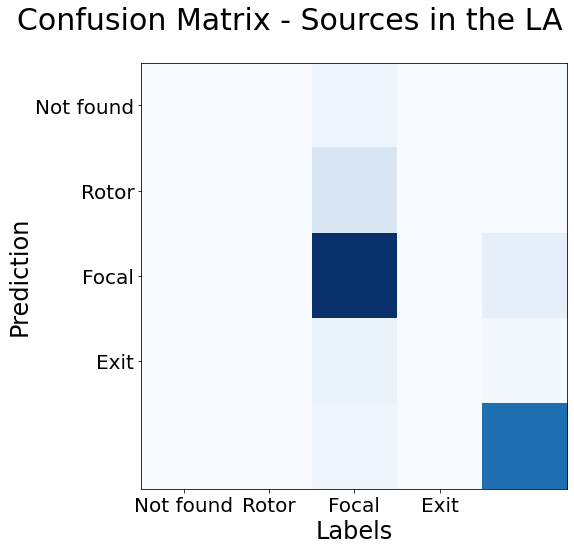

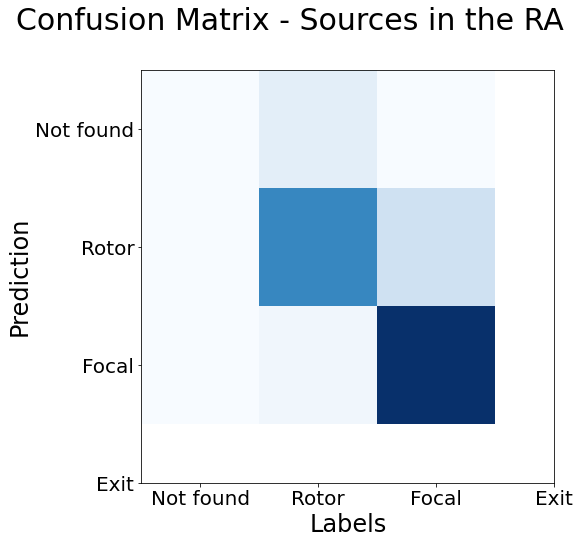

In [145]:
fig,ax = plt.subplots(1,figsize = (8,8))

ax.imshow(laConfusionMatrix.T,cmap = 'Blues')
ax.set_xticks(np.array([0,1,2,3]))
ax.set_yticks(np.array([0,1,2,3]))

ax.set_xticklabels(['Not found','Rotor','Focal','Exit'],fontsize = 20)
ax.set_yticklabels(['Not found','Rotor','Focal','Exit'],fontsize = 20)
ax.set_ylabel('Prediction',fontsize = 24)
ax.set_xlabel('Labels',fontsize = 24)


# for i in range(laConfusionMatrix.shape[0]):
#     for j in range(laConfusionMatrix.shape[1]):
#         percentage = np.round(laConfusionMatrix[i,j],0)#/np.sum(laConfusionMatrix)*100
#         ax.text(i-.2,j,'%d'%percentage,
#                 fontsize = 20,color = 'k',va = 'center')
fig.suptitle('Confusion Matrix - Sources in the LA',fontsize = 30)
fig.tight_layout()

#
fig,ax = plt.subplots(1,figsize = (8,8))

ax.imshow(raConfusionMatrix.T,cmap = 'Blues')
ax.set_xticks(np.array([0,1,2,3]))
ax.set_yticks(np.array([0,1,2,3]))

ax.set_xticklabels(['Not found','Rotor','Focal','Exit'],fontsize = 20)
ax.set_yticklabels(['Not found','Rotor','Focal','Exit'],fontsize = 20)
ax.set_ylabel('Prediction',fontsize = 24)
ax.set_xlabel('Labels',fontsize = 24)

# for i in range(raConfusionMatrix.shape[0]):
#     for j in range(raConfusionMatrix.shape[1]):
#         percentage = np.round(raConfusionMatrix[i,j],0)#/np.sum(raConfusionMatrix)*100
#         ax.text(i-.2,j,'%d'%percentage,
#                 fontsize = 20,color = 'k',va = 'center')
fig.suptitle('Confusion Matrix - Sources in the RA',fontsize = 30)
fig.tight_layout()

In [33]:
tmp = np.zeros_like(laConfusionMatrix)
tmp[[0,1,3],0] = raConfusionMatrix[:,0]
tmp[[0,1,3],1] = raConfusionMatrix[:,1]
tmp[[0,1,3],3] = raConfusionMatrix[:,2]
raConfusionMatrix = tmp

ValueError: shape mismatch: value array of shape (4,)  could not be broadcast to indexing result of shape (3,)

In [61]:
LALabels = np.array(LALabels)
RALabels = np.array(RALabels)

LAExpResults = np.array(LAExpResults)
RAExpResults = np.array(RAExpResults)


## Make an array with all classifications and observe the distances of the missed points

In [193]:
singleOutput = np.empty(4,dtype=int) # experimentIndex, seed, classification, number of steps
for experimentIndex,experimentName in enumerate(experimentNames):
    for seed, res in enumerate(ClassificationResults[experimentIndex]):
        singleOutput = np.vstack([singleOutput,np.array([experimentIndex,seed,res[0],res[1]])])

singleOutput = singleOutput[1:,:]

In [166]:
missedClassifications  = singleOutput[singleOutput[:,2]==0]

missedDistances = list()
for experimentIndex in np.unique(missedClassifications[:,0]):
    for seed in missedClassifications[missedClassifications[:,0]==experimentIndex,1]:
        try:
            missedDistances.append(AllDistances[experimentIndex][seed][-1])
        except IndexError:
            continue
missedDistances

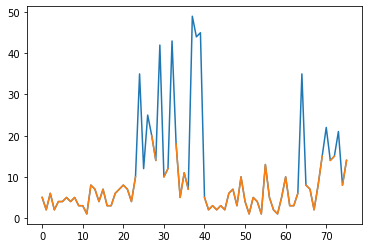

In [200]:
foundClassifications  = singleOutput[singleOutput[:,2]==1]

foundDistances = list()
for experimentIndex in np.unique(foundClassifications[:,0]):
    for seed in foundClassifications[foundClassifications[:,0]==experimentIndex,1]:
        try:
            foundDistances.append(AllDistances[experimentIndex][seed][-1])
        except IndexError:
            continue
plt.plot(DistancesWhenFound)
test = deepcopy(DistancesWhenFound)
test[DistancesWhenFound>20] = np.nan
plt.plot(test)


In [198]:
from copy import deepcopy

In [ ]:
Definition of proper rotor detection